## Imporerer pakker

In [13]:
import pandas as pd
import numpy as np



# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, log_loss, confusion_matrix

from sklearn.compose import TransformedTargetRegressor

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor


# Classification Models
from sklearn.linear_model import LogisticRegression, HuberRegressor, BayesianRidge, LassoLars, PassiveAggressiveRegressor, TheilSenRegressor, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Other Model Utilities
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import plot_tree

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn import set_config
import plotly.express as px
from sklearn.compose import TransformedTargetRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import TransformedTargetRegressor
from scipy import stats
from xgboost import XGBRegressor
from sklearn.preprocessing import TargetEncoder
import shap
from sklearn.preprocessing import MinMaxScaler
import pickle

## Laster inn filer

In [14]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('validation_df.csv')
test_df = pd.read_csv('test_df.csv')

pd.set_option('display.max_columns', None)
pd.reset_option('display.float_format')

# Variabelutvinning

## Klassifikasjonsmodell for sykehusdød

In [15]:
# Forbered trenings- og valideringsdatasett
from preprocessing import prepare_data_for_death_classification, get_col_transformer
# Step 1: Train and save the classification model for imputing `sykehusdød`

# Prepare training and validation datasets for classification
X_train_classification, numeric_cols, categorical_cols, y_train = prepare_data_for_death_classification(train_df)
X_val_classification, _, _, y_val = prepare_data_for_death_classification(val_df)
X_test_classification, _, _, y_test = prepare_data_for_death_classification(test_df)

# Set up ColumnTransformer and classification pipeline
preprocessor = get_col_transformer(numeric_cols, categorical_cols, passthrough_cols=['demens'])
classification_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the classifier
classification_pipeline.fit(X_train_classification, y_train)

# Validate and save the model
y_val_pred = classification_pipeline.predict(X_val_classification)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

y_test_pred = classification_pipeline.predict(X_test_classification)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.2f}")
# Save the classification model for future use
with open('sykehusdod_model.pkl', 'wb') as f:
    pickle.dump(classification_pipeline, f)

Validation Accuracy: 0.84
Test Accuracy: 0.81


In [16]:
if 'sykehusdød' in val_df.columns:
    val_df = val_df.drop(columns=['sykehusdød'])
if 'sykehusdød' in test_df.columns:
    test_df = test_df.drop(columns=['sykehusdød'])
# Prepare data for classification and predict `sykehusdød`
X_val_classification, _, _, _ = prepare_data_for_death_classification(val_df, prediction_mode=True)
X_test_classification, _, _, _ = prepare_data_for_death_classification(test_df, prediction_mode=True)

# Impute `sykehusdød`
val_df['sykehusdød'] = classification_pipeline.predict(X_val_classification)
test_df['sykehusdød'] = classification_pipeline.predict(X_test_classification)


## Oppretter nye variabler, og splitter target/features

In [17]:
from preprocessing import prepare_data_for_length_prediction

# Step 1: Prepare the data for length prediction
X_train, numeric_cols_train, categorical_cols_train, y_train = prepare_data_for_length_prediction(train_df, prediction_mode=False)
X_val, numeric_cols_val, categorical_cols_val, y_val = prepare_data_for_length_prediction(val_df, prediction_mode=False)
X_test, numeric_cols_test, categorical_cols_test, y_test = prepare_data_for_length_prediction(test_df, prediction_mode=False)

## Imputerer manglende verdier og oneHotEncoder kategoriske variabler

In [18]:

# We use the `numeric_cols_train` and `categorical_cols_train` from the prepare_data_for_length_prediction function
passthrough_cols = ['sykehusdød', 'demens', 'diabetes', 'omfattende_behandling']
col_transformer = get_col_transformer(numeric_cols_train, categorical_cols_train, passthrough_cols)

# Step 3: Fit and transform the training data
X_train_imputed = col_transformer.fit_transform(X_train)

# Step 4: Transform the validation and test data
X_val_imputed = col_transformer.transform(X_val)
X_test_imputed = col_transformer.transform(X_test)

# Step 5: Get feature names (numeric and one-hot encoded categorical columns)
# Step 5: Get feature names for numeric and one-hot encoded categorical columns
numeric_feature_names = numeric_cols_train  # Numeric columns
categorical_feature_names = col_transformer.named_transformers_['cat_pipeline']\
    .named_steps['one-hot-encoder'].get_feature_names_out([col for col in categorical_cols_train if col not in passthrough_cols])

# Combine numeric and categorical feature names
feature_names = list(numeric_feature_names) + list(categorical_feature_names) + passthrough_cols

# Step 6: Convert the transformed data back into DataFrames with the correct column names
X_train_imputed = pd.DataFrame(X_train_imputed, columns=feature_names)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=feature_names)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=feature_names)


In [37]:
X_val_imputed

,alder,utdanning,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,antall_komorbiditeter,koma_score,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,glukose,blodurea_nitrogen,urinmengde,alder_fysiologisk_interaction,kjønn_female,kjønn_male,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,sykdomskategori_ARF/MOSF,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_Cancer,sykdomskategori_Coma,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,inntekt_8.0,inntekt_20.0,inntekt_35.0,age_binned_middle-aged,age_binned_senior,age_binned_young,alvorlighetsgrad_høy,alvorlighetsgrad_lav,alvorlighetsgrad_middels,sykehusdød,demens,diabetes,omfattende_behandling
0,0.457457,1.385877,0.462822,-0.900431,0.062171,-0.377602,0.854676,0.168978,0.443416,-0.464959,1.071429,0.352311,0.10489,-0.497298,-1.07674,-1.140831,0.433349,-0.160595,0.0,-0.581604,0.131832,-0.773412,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,False
1,0.90736,1.064144,-0.798801,-1.111104,-1.263846,-0.913555,2.523625,0.522808,-0.068639,0.421851,1.236982,0.917657,0.10489,-0.497298,-0.489016,-0.44252,0.632697,0.581407,0.830057,1.88191,-1.210022,0.000692,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,False
2,-2.499048,0.0,1.056527,0.341403,1.321888,0.051161,2.045891,0.325631,-1.602932,-0.169356,-0.584099,-0.488812,-1.399134,-0.14008,-0.150507,0.006395,1.016284,1.296086,0.0,-0.581604,0.131832,-1.408286,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0,False
3,-1.984873,0.098945,-0.650375,0.895615,-0.633988,0.051161,1.171094,2.058491,-0.452056,5.210395,-0.749652,0.352311,-0.647122,-0.497298,-0.867603,-0.39264,0.588831,0.094408,1.936469,1.196291,0.131832,-1.460447,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0,False
4,0.586001,0.098945,-0.798801,-0.567774,0.393676,0.158352,-0.888716,-0.420739,-0.452056,1.071948,-1.24631,0.490205,-0.647122,1.923843,1.253726,1.452898,-2.485364,-2.017903,0.0,-0.581604,0.131832,1.604926,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,0.071826,-0.222788,-0.873014,-0.589973,0.161623,-0.377602,-1.050023,0.675711,1.466279,-0.464959,0.078112,-0.0,1.608913,-0.497298,-1.166426,-1.041072,1.135698,1.346895,0.0,-0.581604,0.131832,-0.976564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,True
1156,1.164448,0.0,-1.095653,-0.501286,-0.866041,1.230258,-0.175225,-0.888581,0.443416,-0.64235,0.409218,0.076535,1.608913,1.249099,-0.658271,-0.143243,-0.10572,-0.062572,-0.752727,-0.174947,-0.935857,-0.075397,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1,False
1157,1.100176,0.0,1.279166,2.780673,2.581605,0.479923,-0.888716,-0.388683,-1.091501,-0.64235,0.740324,1.207228,0.10489,1.130027,-0.807683,-0.093364,0.421164,0.553606,-0.199521,1.15344,-0.480641,-0.268256,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,False
11

## Grunnlinjemodeller

In [11]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
prediction = baseline.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

21.59611100410102

In [12]:
baseline2 = DummyRegressor(strategy='median')
baseline2.fit(X_train, y_train)
prediction = baseline2.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

22.712103715253104

In [39]:
y_train.value_counts()

oppholdslengde
5      403
7      395
4      393
6      360
9      297
      ... 
185      1
105      1
164      1
343      1
132      1
Name: count, Length: 145, dtype: int64

## Modellering

## Visualisering av actual vs predicted

In [8]:
def plot_actual_vs_pred(y_actual, y_pred, model_name):
    df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    fig = px.scatter(df, x='Actual', y='Predicted', title=f"{model_name}: Actual vs. Predicted")
    fig.add_shape(type="line", x0=df['Actual'].min(), y0=df['Actual'].min(),
                  x1=df['Actual'].max(), y1=df['Actual'].max(), line=dict(color='Red', dash='dash'))
    fig.show()


## RandomForestRegression

In [9]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_imputed, y_train)

# Evaluate the model on validation data
y_val_pred_rf = model_rf.predict(X_val_imputed)
rmse_val_rf = (root_mean_squared_error(y_val, y_val_pred_rf))
print(f"RMSE on Validation Set (RandomForest): {rmse_val_rf:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_rf, "Random Forest with Target Encoding")

RMSE on Validation Set (RandomForest): 21.258


## ExtraTreesRegressor

In [40]:
# Define and train ExtraTrees model
model_et = ExtraTreesRegressor(random_state=42)
model_et.fit(X_train_imputed, y_train)

# Evaluate on validation data
y_val_pred_et = model_et.predict(X_val_imputed)
rmse_val_et = (root_mean_squared_error(y_val, y_val_pred_et))
print(f"RMSE on Validation Set (ExtraTrees): {rmse_val_et:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_et, "Random Forest with Target Encoding")

RMSE on Validation Set (ExtraTrees): 21.106


## Ridge

In [69]:
model_ridge = Ridge(random_state=42)  # You can adjust alpha as needed
model_ridge.fit(X_train_imputed, y_train)

# Predict and clip negative values to zero
y_val_pred = model_ridge.predict(X_val_imputed)
y_val_pred = np.maximum(y_val_pred, 0)
rmse_val = root_mean_squared_error(y_val, y_val_pred)
print(f"RMSE on Validation Set (Ridge with Clipping): {rmse_val:.3f}")
plot_actual_vs_pred(y_val, y_val_pred, "Random Forest with Target Encoding")

RMSE on Validation Set (Ridge with Clipping): 20.495


## Feature Importance for Ridge

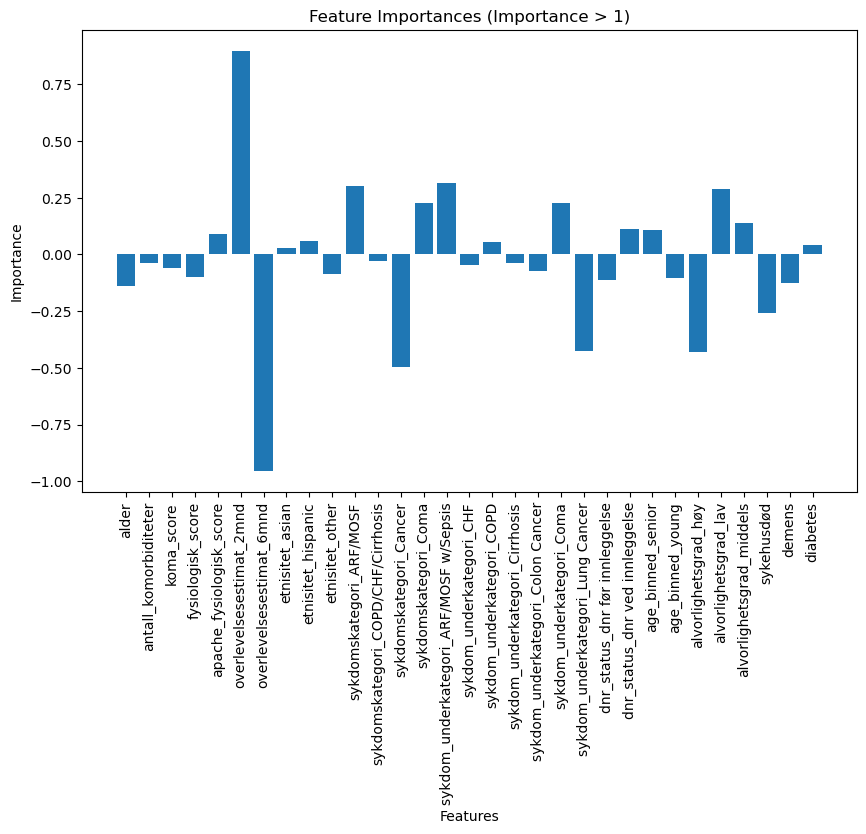

In [65]:
import matplotlib.pyplot as plt
import numpy as np
importance = model_ridge.coef_
# Ensure importance is an array and feature names align in length
assert len(importance) == len(feature_names), "Length mismatch between importance and feature_names"

# Filter for importance values greater than 1 (absolute)
filtered_importance = [imp for imp in importance if abs(imp) >= 0.03]
filtered_feature_names = [feature_names[i] for i in range(len(importance)) if abs(importance[i]) >= 0.03]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(filtered_importance)), filtered_importance)
plt.xticks(range(len(filtered_importance)), filtered_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances (Importance > 1)")
plt.show()


## Finner best Alpha for Ridge

In [57]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

# Define the parameter grid for alpha
param_grid = {'alpha': np.logspace(-3, 3, 10)}  # Range from 0.001 to 1000

# Set up GridSearchCV with Ridge model
ridge_cv = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV on the training data
ridge_cv.fit(X_train_imputed, y_train)

# Get the best alpha and corresponding RMSE score
best_alpha = ridge_cv.best_params_['alpha']
best_rmse = -ridge_cv.best_score_  # Negative because of scoring convention
print(f"Best Alpha: {best_alpha}")
print(f"Best RMSE Score: {best_rmse:.3f}")

# Train a Ridge model with the best alpha and predict with clipping
best_ridge_model = Ridge(alpha=best_alpha, random_state=42)
best_ridge_model.fit(X_train_imputed, y_train)

# Predict and clip negative values to zero
y_val_pred_best = best_ridge_model.predict(X_val_imputed)
y_val_pred_best = np.maximum(y_val_pred_best, 0)
rmse_val_best = (root_mean_squared_error(y_val, y_val_pred_best))
print(f"Optimized RMSE on Validation Set with Clipping: {rmse_val_best:.3f}")


Best Alpha: 2.154434690031882
Best RMSE Score: 19.813
Optimized RMSE on Validation Set with Clipping: 20.494


## Hyperparametertuning ExtraTreesRegressor

In [68]:
from sklearn.model_selection import RandomizedSearchCV

X_train_full = X_train_imputed
X_val_full = X_val_imputed

# Define the parameter grid for ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [10, 20, 50, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Initialize RandomizedSearchCV for ExtraTreesRegressor
random_search_et = RandomizedSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_distributions=param_grid_et,
    n_iter=50,  # Number of random parameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search model on the full feature set (X_train_full)
random_search_et.fit(X_train_full, y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {random_search_et.best_params_}")

# Best RMSE score
best_rmse = -random_search_et.best_score_
print(f"Best RMSE Score: {best_rmse:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model = random_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et = best_et_model.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et = root_mean_squared_error(y_val, y_val_pred_best_et)
print(f"RMSE on Validation Set with Full Features: {rmse_best_et:.3f}")

# Call the plot_actual_vs_pred function to visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et, "Best ExtraTreesRegressor with Full Features")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators

## Hyperparamtertuning for ExtraTreesRegressor 

In [32]:
from sklearn.model_selection import GridSearchCV

# Use the best parameters as the center of the grid
param_grid_et_refined = {
    'n_estimators': [400, 500, 550],  # Around 200
    'max_depth': [None],        # Around 50
    'min_samples_split': [4, 5, 6], # Around 10
    'min_samples_leaf': [3, 4, 5],    # Around 4
    'bootstrap': [True]               # Keep as True based on RandomizedSearch result
}

# Initialize GridSearchCV for ExtraTreesRegressor
grid_search_et = GridSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_grid=param_grid_et_refined,
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search model on the full feature set (X_train_full)
grid_search_et.fit(X_train_full, y_train)

# Best hyperparameters from GridSearch
print(f"Best Hyperparameters from GridSearch: {grid_search_et.best_params_}")

# Best RMSE score from GridSearch
best_rmse_grid = -grid_search_et.best_score_
print(f"Best RMSE Score from GridSearch: {best_rmse_grid:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model_grid = grid_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et_grid = best_et_model_grid.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et_grid = root_mean_squared_error(y_val, y_val_pred_best_et_grid)
print(f"RMSE on Validation Set with Full Features (GridSearch): {rmse_best_et_grid:.3f}")

# Visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et_grid, "Best ExtraTreesRegressor with Full Features (GridSearch)")



Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=500; total

## Laster ned beste modell

In [30]:
with open('model.pkl', 'wb') as f:
    pickle.dump((best_et_model_grid, col_transformer, feature_names), f)

In [70]:
# Get feature importances from the best model after GridSearch
importances = best_et_model_grid.feature_importances_

# Create a DataFrame to display feature importances with the correct features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Use the feature names from X_train_full
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
feature_importance_df.T


,33,15,16,17,52,14,4,0,10,8,2,12,6,3,13,5,11,7,1,21,46,47,43,9,54,23,22,19,29,18,28,31,45,44,55,20,25,30,48,34,32,35,38,26,24,40,53,36,39,41,42,37,51,49,27,50
Feature,sykdom_underkategori_ARF/MOSF w/Sepsis,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,sykehusdød,fysiologisk_score,hjertefrekvens,alder,natrium,serumalbumin,blodtrykk,antall_komorbiditeter,kroppstemperatur,hvite_blodlegemer,koma_score,respirasjonsfrekvens,blod_ph,lungefunksjon,utdanning,alder_fysiologisk_interaction,age_binned_middle-aged,age_binned_senior,inntekt_8.0,kreatinin,diabetes,kjønn_male,kjønn_female,blodurea_nitrogen,sykdomskategori_ARF/MOSF,glukose,etnisitet_white,sykdomskategori_Cancer,inntekt_35.0,inntekt_20.0,omfattende_behandling,urinmengde,etnisitet_black,sykdomskategori_COPD/CHF/Cirrhosis,age_binned_young,sykdom_underkategori_CHF,sykdomskategori_Coma,sykdom_underkategori_COPD,sykdom_underkategori_Coma,etnisitet_hispanic,etnisitet_asian,sykdom_underkategori_MOSF w/Malig,demens,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Lung Cancer,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,sykdom_underkategori_Colon Cancer,alvorlighetsgrad_middels,alvorlighetsgrad_høy,etnisitet_other,alvorlighetsgrad_lav
Importance,0.16557,0.063405,0.049698,0.046711,0.046526,0.03393,0.02996,0.027573,0.027552,0.027107,0.026257,0.02582,0.025733,0.024151,0.022451,0.022375,0.021973,0.020167,0.019848,0.019341,0.018054,0.016854,0.016274,0.016263,0.014587,0.013825,0.013632,0.013396,0.012314,0.012256,0.012007,0.011657,0.011265,0.010548,0.010367,0.009652,0.007146,0.005579,0.003943,0.00379,0.003489,0.00292,0.002888,0.002197,0.001952,0.001812,0.001476,0.0014,0.000558,0.000336,0.000329,0.000316,0.00026,0.000257,0.000226,0.000032
